In [1]:
from glob import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

In [2]:
from albumentations.core.transforms_interface import ImageOnlyTransform, DualTransform, to_tuple
import random
import numpy as np
import cv2
import math

COLOR_CODE = {
    "Building": [128, 0, 0],
    "Car": [0, 0, 128],
    "Vegetation": [0, 128, 128],
    "Wall": [128, 128, 128],
    "ManmadeStructure": [64, 0, 0],
    "Road": [192, 0, 0],
    "Sky": [64, 128, 0],
    "Billboard": [192, 0, 128],
    "SignSymbol": [192, 128, 0],
    "SignPole": [64, 0, 128],
}

class GetMaskOneHot(DualTransform):
    def __init__(self, always_apply: bool = False, p: float = 0.5):
        super().__init__(always_apply, p)
        
    def apply(self, img, **params) -> np.ndarray:
        return img
    
    def apply_to_mask(self, img, **params):
        return self.get_masks_one_hot(img, COLOR_CODE)
    
    def get_masks_one_hot(self, mask, color_codes):
        n_channels = len(color_codes.keys())  # N_CLASSES
        mask_channels = np.zeros(
            (mask.shape[0], mask.shape[1], n_channels), dtype=np.float64)
        
        for i, cls in enumerate(color_codes.keys()):
            color = color_codes[cls]
            sub_mask = np.all(mask == color, axis=-1) * 1
            mask_channels[:, :, i] = sub_mask
        return mask_channels

class Resize(DualTransform):
    def __init__(self, always_apply: bool = False, p: float = 0.5):
        super().__init__(always_apply, p)

    def apply(self, img, **params) -> np.ndarray:
        return cv2.resize(img, (256, 256))

    def apply_to_mask(self, img, **params):
        return cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)


class HistogramEqualization(ImageOnlyTransform):
    def __init__(self, always_apply: bool = False, p: float = 0.5):
        super().__init__(always_apply, p)

    def apply(self, img, **params) -> np.ndarray:
        return self.hist_equalized_hsv(img)

    def hist_equalized_hsv(self, image):
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(5, 5))
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        hue, sat, val = cv2.split(hsv)
        aeq = clahe.apply(val)

        hsv = cv2.merge((hue, sat, aeq))
        img_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return img_rgb


class RandomRotation(DualTransform):
    def __init__(self, limit, always_apply: bool = False, p: float = 0.5):
        super().__init__(always_apply, p)
        self.limit = to_tuple(limit)

    def apply(self, img, angle=0, **params) -> np.ndarray:
        image_height, image_width = img.shape[0:2]
        rotated_image = self.rotateImage(img, angle)
        return self.crop_around_center(
            rotated_image,
            *self.largest_rotated_rect(
                image_width,
                image_height,
                math.radians(angle)
            )
        )

    def apply_to_mask(self, img, angle=0, **params):
        image_height, image_width = img.shape[0:2]
        rotated_image = self.rotateImage(
            img, angle, interpolateMode=cv2.INTER_NEAREST)
        return self.crop_around_center(
            rotated_image,
            *self.largest_rotated_rect(
                image_width,
                image_height,
                math.radians(angle)
            )
        )

    def get_params(self):
        return {"angle": random.uniform(self.limit[0], self.limit[1])}

    def rotateImage(self, image, angle, interpolateMode=cv2.INTER_LINEAR):
        """
        Rotates the given image about it's centre
        """
        def getTranslationMatrix2d(dx, dy):
            return np.matrix([[1, 0, dx], [0, 1, dy], [0, 0, 1]])

        image_size = (image.shape[1], image.shape[0])
        image_center = tuple(np.array(image_size) / 2)

        rot_mat = np.vstack([cv2.getRotationMatrix2D(
            image_center, angle, 1.0), [0, 0, 1]])
        trans_mat = np.identity(3)

        w2 = image_size[0] * 0.5
        h2 = image_size[1] * 0.5

        rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

        tl = (np.array([-w2, h2]) * rot_mat_notranslate).A[0]
        tr = (np.array([w2, h2]) * rot_mat_notranslate).A[0]
        bl = (np.array([-w2, -h2]) * rot_mat_notranslate).A[0]
        br = (np.array([w2, -h2]) * rot_mat_notranslate).A[0]

        x_coords = [pt[0] for pt in [tl, tr, bl, br]]
        x_pos = [x for x in x_coords if x > 0]
        x_neg = [x for x in x_coords if x < 0]

        y_coords = [pt[1] for pt in [tl, tr, bl, br]]
        y_pos = [y for y in y_coords if y > 0]
        y_neg = [y for y in y_coords if y < 0]

        right_bound = max(x_pos)
        left_bound = min(x_neg)
        top_bound = max(y_pos)
        bot_bound = min(y_neg)

        new_w = int(abs(right_bound - left_bound))
        new_h = int(abs(top_bound - bot_bound))
        new_image_size = (new_w, new_h)

        new_midx = new_w * 0.5
        new_midy = new_h * 0.5

        dx = int(new_midx - w2)
        dy = int(new_midy - h2)

        trans_mat = getTranslationMatrix2d(dx, dy)
        affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]
        result = cv2.warpAffine(
            image, affine_mat, new_image_size, flags=interpolateMode)

        return result

    def largest_rotated_rect(self, w, h, angle):
        """
        Given a rectangle of size wxh that has been rotated by 'angle' (in
        radians), computes the width and height of the largest possible
        axis-aligned rectangle within the rotated rectangle.
        """
        quadrant = int(math.floor(angle / (math.pi / 2))) & 3
        sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
        alpha = (sign_alpha % math.pi + math.pi) % math.pi

        bb_w = w * math.cos(alpha) + h * math.sin(alpha)
        bb_h = w * math.sin(alpha) + h * math.cos(alpha)

        gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

        delta = math.pi - alpha - gamma

        length = h if (w < h) else w

        d = length * math.cos(alpha)
        a = d * math.sin(alpha) / math.sin(delta)

        y = a * math.cos(gamma)
        x = y * math.tan(gamma)

        return (bb_w - 2 * x, bb_h - 2 * y)

    def crop_around_center(self, image, width, height):
        """
        Given a NumPy / OpenCV 2 image, crops it to the given width and height,
        around it's centre point
        """
        image_size = (image.shape[1], image.shape[0])
        image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

        if(width > image_size[0]):
            width = image_size[0]

        if(height > image_size[1]):
            height = image_size[1]

        x1 = int(image_center[0] - width * 0.5)
        x2 = int(image_center[0] + width * 0.5)
        y1 = int(image_center[1] - height * 0.5)
        y2 = int(image_center[1] + height * 0.5)

        return image[y1:y2, x1:x2]

In [3]:
image_path = "E:\\KenkeiDataset\\【0124納品】20211227_100SampleTasuki\\JPEGImages"
mask_path = "E:\\KenkeiDataset\\【0124納品】20211227_100SampleTasuki\\SegmentationClassPNG"

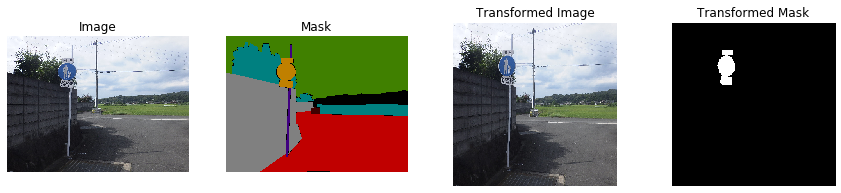

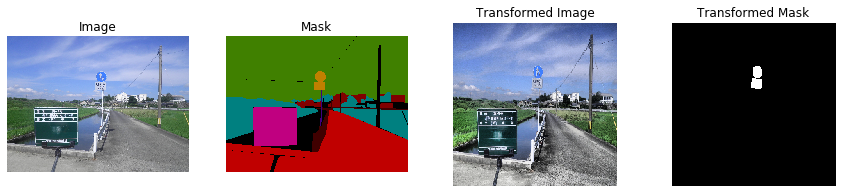

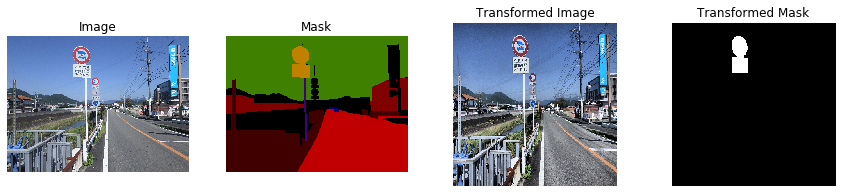

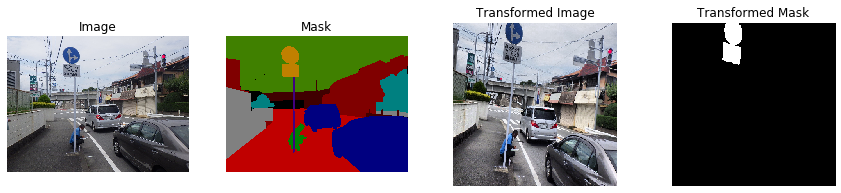

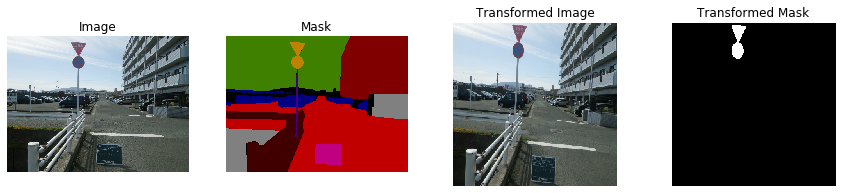

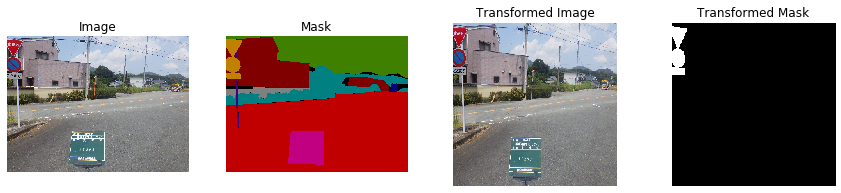

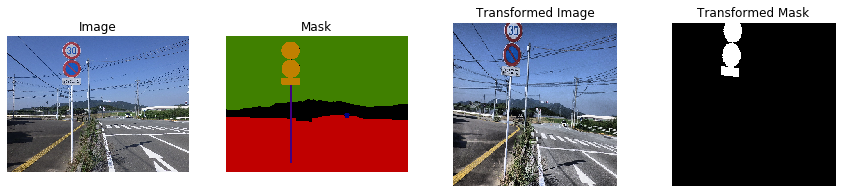

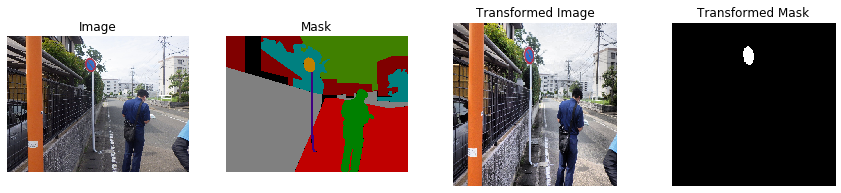

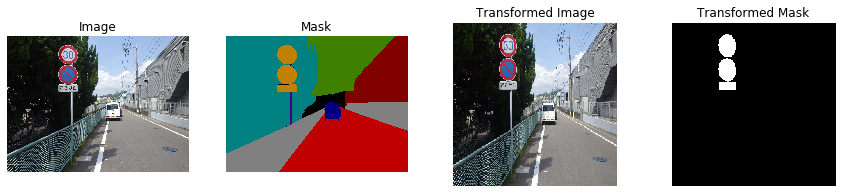

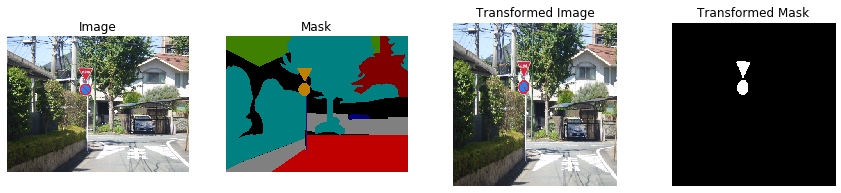

In [6]:
image_filenames = np.sort(glob(os.path.join(image_path, "*")))[:10]
mask_filenames = np.sort(glob(os.path.join(mask_path, "*")))[:10]
transform = A.Compose([
    RandomRotation(p=0.5, limit=(-10, 10)),
    Resize(always_apply=True),
    GetMaskOneHot(always_apply=True),
    HistogramEqualization(p=0.5),
])
for image_filename, mask_filename in zip(image_filenames, mask_filenames):
    image = cv2.imread(image_filename)
    mask = cv2.imread(mask_filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    transformed = transform(image=image, mask=mask)
    image_transformed = transformed["image"]
    mask_transformed = transformed["mask"]
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask)
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(image_transformed)
    plt.title("Transformed Image")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(mask_transformed[:, :, -2], cmap="gray")
    plt.title("Transformed Mask")
    plt.axis("off")

    plt.show()